
# Amazon Fine Food Reviews

## Introduction

### Initial goals

1. Perform some basic exploratory analysis to better understand reviews
2. What's in a review? Is it positive or negative?
3. What relationships exist between factors?

Note: This notebook is inspired from the [Exploratory visualization of Amazon fine food reviews by Rob Castellano](https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/)


### Data Extraction  

* Data source: (https://www.kaggle.com/snap/amazon-fine-food-reviews)
* About the data attributes

 * Score(Rating 1-5 stars)
 * The reivew
 * A summary of the review
 * Number of users who found the review helpful
 * Number of users who indicated whether they found the review helpful
 * Timestamp for the review 
 * Unqiue identifier for the user
 * Unique identifier for the product

All data in one excel file.568,454 food reviews Amazon users left up to October 2012.


In [129]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import sqlite3 as sql
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import model_selection
import statsmodels.api as smf
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from patsy import dmatrices

#retrieve data from dropbox file
df = pd.read_csv('https://www.dropbox.com/s/w5kkg7svxk7ssec/Reviews.csv?dl=1')
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [130]:
# observing the shape
df.shape

(568454, 10)

#### Due to memory limits , I can only randomly select 3% of the original Amazon food reviews dataset here 

In [177]:
df1 = df.sample(frac=0.03,replace= False)

In [178]:
# check missing values
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17054 entries, 203566 to 109404
Data columns (total 10 columns):
Id                        17054 non-null int64
ProductId                 17054 non-null object
UserId                    17054 non-null object
ProfileName               17054 non-null object
HelpfulnessNumerator      17054 non-null int64
HelpfulnessDenominator    17054 non-null int64
Score                     17054 non-null int64
Time                      17054 non-null int64
Summary                   17053 non-null object
Text                      17054 non-null object
dtypes: int64(5), object(5)
memory usage: 1.4+ MB


## Exploratory analysis

###  Distribution of ratings
* It shows that 5 star reviews consititute a large proportion, the next prevalent rating is 4-stars.

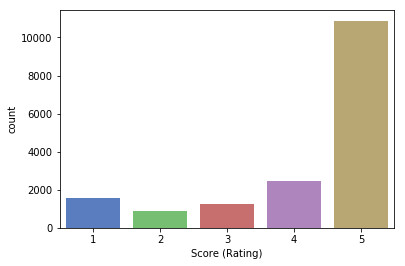

In [179]:
plt.figure()
sns.countplot(x='Score', data=df1, palette='muted')
plt.xlabel('Score (Rating)')
plt.show()


### How many reviews are positive?

* Score >3 then 'positive',Score < 3 then 'negative', Score = 3 then 'neutral' 
* Posititive reviews are very common 

positive    13321
negative     2467
neutral      1266
Name: Positivity, dtype: int64

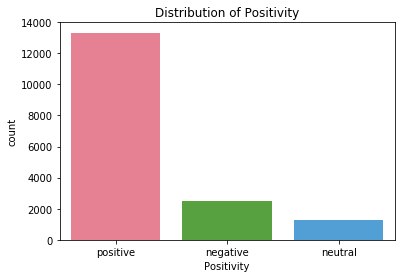

In [194]:

df2=df1.loc[:,['UserId','HelpfulnessNumerator','HelpfulnessDenominator', 'Summary','Text','Score']]
df2['Positivity']= df2['Score'].apply(lambda score: "positive" if score >3 else "negative" if score <3 else "neutral")

# plot the count for "Positivity"
sns.countplot(x='Positivity',data = df2,order=['positive','negative','neutral'],palette="husl")
plt.title('Distribution of Positivity')
df2['Positivity'].value_counts()

### How many reviews are helpful? 

* Among all reviews, almost half are not voted at all. 
* For voted reviews, helpful reviews are the most common.

No Indication    8115
>75%             6062
25-75%           1724
<25%             1153
Name: Helpfulness, dtype: int64

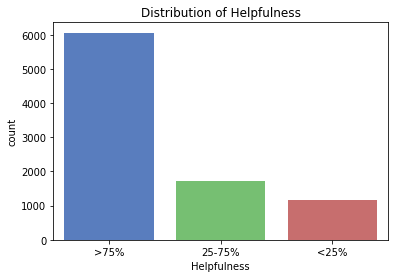

In [195]:
# check the value count for "helpfulness" 

df2['Helpfulness']= (df2["HelpfulnessNumerator"]/df2["HelpfulnessDenominator"]).apply\
(lambda n:">75%" if n > 0.75 else ("25-75%" if n >= 0.25 and n<=0.75 else ("<25%" if n<0.25 else "No Indication")))
df2['Helpfulness'].value_counts()
sns.countplot(x='Helpfulness',order=['>75%',"25-75%",'<25%'],data = df2,palette="muted")
plt.title('Distribution of Helpfulness') 
df2['Helpfulness'].value_counts()


### How do ratings affect helpfulness?

* The reviews become more helpful as the rating becomes more positive.

Text(0.5,1,'Helpfulness by Scores')

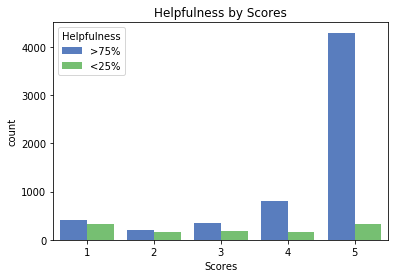

In [196]:
sns.countplot(x="Score", hue="Helpfulness",hue_order=['>75%', '<25%'], data= df2,palette="muted")
plt.xlabel('Scores')
plt.title('Helpfulness by Scores')

### Word count

* The more positive reviews had the lowest median word count.

Text(0.5,1,'Word Count by Rating')

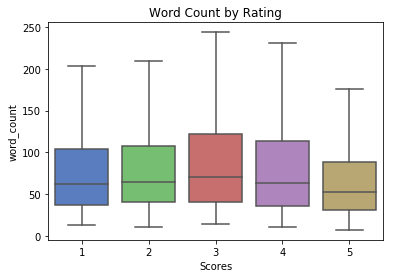

In [198]:
# word count
df2['word_count']= df2['Text'].apply(lambda text: len(text.split()))
# word count by score
sns.boxplot(x="Score", y='word_count',data= df2,palette="muted",showfliers=False)
plt.xlabel('Scores')
plt.title('Word Count by Rating')

### How does word count relate to helpfulness ?

* Helpful reviews and not helpful reviews have a similar distribution at the greatest concentration counts.
* Helpful reviews tend to have longer reviews compared to not helpful reviews.

(-30, 500)

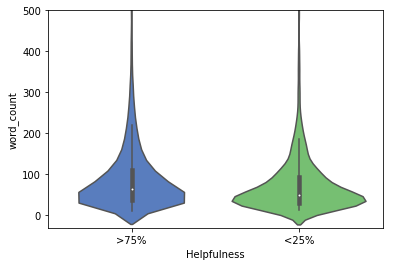

In [199]:
sns.violinplot(x="Helpfulness", y="word_count",order= ['>75%',"<25%"], data= df2,palette="muted")
plt.ylim(-30,500)

## Model buidling 

In [186]:
df3 = df2.loc[:,['UserId','Summary','Text','Positivity']]
total_size = len(df3)
print 'len df3 is %d' % len(df3)


len df3 is 17054


In [200]:
# remove all 'neutral' values
data= df3[df3.Positivity!= 'neutral']
data.Positivity.replace(['positive', 'negative'], [1, 0], inplace=True)
data.shape

(15788, 4)

In [188]:
# countvectorizer converts a collection of text documents into a matrix of token counts(see how often each word occurs)
#  convert the text document into a matrix of token counts
vect = CountVectorizer(analyzer = 'word',
    lowercase = False)
features = vect.fit_transform(
    data.Text
)

# for easy usage
features_nd = features.toarray() 

In [212]:
# split data into training and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test  = train_test_split(
        features_nd, 
        data.Positivity,
        train_size=0.70, 
        )

## Models
Here I will implement various models and comparing their AUC values. 

* Naive Bayes
* Logistic Regression
* Random Forest


In [213]:
# Naive Bayes
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()
nb.fit(X_train,y_train)
#make predictions using vect_test
predictions = nb.predict(X_test)
print('AUC:',roc_auc_score(y_test, predictions))


('AUC:', 0.6972140762463344)


In [214]:

# logistic Regression - train logistic regression classifier based on matrix X_train
from sklearn.linear_model import LogisticRegression
model= LogisticRegression()
model.fit(X_train,y_train)
# make prediction using X_test and compute AUC
predictions = model.predict(X_test)
print('AUC: ', roc_auc_score(y_test, predictions))



('AUC: ', 0.7879191811476536)


In [215]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier()
model.fit(X_train,y_train)
# make prediction using X_test and compute AUC
predictions = model.predict(X_test)
print('AUC: ', roc_auc_score(y_test, predictions))



('AUC: ', 0.5984525338697559)


* We can see that Logistic regression model performed better than Naive Bayes and Random Forest on the Amazon food reviews dataset.


# Conclusions

* Positive reviews are very common
* Longer reviews are more helpful
* Positive reviews are shorter
* Positive reviews are more helpful 

The results are not bad but further analysis can be conducted to better understand how models make these predictions in order to improve the results.